# Meta Classification

In this notebook, classifiers are trained to be able to find optimal base level algorithm per user.
Random Forest classifier is used for classification.
Binary Particle Swarm Optimization is used to find optimal subsets of base level algorithms and features used.

This notebook is structured as follows:

    1 Domain independent features
        1.1 Main metric to optimize: accuracy
            1.1.1 Complete set of base level algorithms
                1.1.1.1 Model training
                1.1.1.2 Model evaluation
                1.1.1.3 Feature importances
        1.2 Main metric to optimize: NDCG@100
            1.2.1 Complete set of base level algorithms
                1.2.1.1 Model training
                1.2.1.2 Model evaluation
                1.2.1.3 Feature importances
            1.2.2 Searching for optimal subset of base level algorithms and features
            1.2.3 Tuning model using algorithm and feature subsets
                1.2.3.1 Model evaluation
                1.2.3.2 Feature importances
            1.2.4 Tuning model using algorithm subset only
                1.2.4.1 Model evaluation
                1.2.4.2 Feature importances                

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import pyswarms as ps

import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [16, 6]

In [3]:
DATA_PATH = 'data/ustore/'
METRICS = ['NDCG@100', 'RR@100', 'P@10', 'R@10']
NUM_THREADS = 8
CV_FOLDS = 5
RS_ITERATIONS = 100
RAND_STATE = 1739
TEST_SIZE = 0.3

In [4]:
# load users with existing optimal rs algorithm and their features
data = pd.read_csv(DATA_PATH+'meta/data.csv')
data.head()

,user_id,class,unique_items,users_sharing_1,users_sharing_1+,users_sharing_10%+,users_sharing_2,users_sharing_2+,users_sharing_20%+,users_sharing_3,...,ds_category5_top_count_normalized,ds_category6_nunique,ds_category6_top_count,ds_category6_top_count_normalized,ds_category_last_nunique,ds_category_last_top_count,ds_category_last_top_count_normalized,ds_gender_nunique,ds_gender_top_count,ds_gender_top_count_normalized
0,1,bpr,23,494,549,0,55,55,0,0,...,1.0,1.0,23.0,1.0,7.0,16.0,0.695652,2.0,19.0,0.826087
1,4,userknn,2,61,62,62,1,1,62,0,...,1.0,1.0,2.0,1.0,2.0,1.0,0.500000,2.0,1.0,0.500000
2,5,bpr,3,309,311,311,2,2,311,0,...,1.0,1.0,3.0,1.0,3.0,1.0,0.333333,3.0,1.0,0.333333
3,6,popular,9,132,134,134,2,2,2,0,...,1.0,1.0,9.0,1.0,6.0,3.0,0.333333,3.0,4.0,0.444444
4,8,als,3,63,69,69,5,6,69,1,...,1.0,1.0,3.0,1.0,1.0,3.0,1.000000,2.0,2.0,0.666667


In [5]:
# load all users rs performance evaluations
all_users_performance = pd.read_csv(DATA_PATH+'rs_performance.csv')
for m in METRICS:
    all_users_performance[m] = all_users_performance[m].apply(literal_eval)
all_users_performance.head()

,NDCG@100,P@10,R@10,RR@100,user_id
0,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",0
1,"[[0.11838279295536291, bpr], [0.05780921899607...","[[0.1, bpr], [0.0, userknn], [0.0, popular], [...","[[0.14285714285714285, bpr], [0.0, userknn], [...","[[0.25, bpr], [0.038461538461538464, als], [0,...",1
2,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",2
3,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",3
4,"[[0.5802792108518124, userknn], [0.37007816335...","[[0.2, userknn], [0.1, bpr], [0.0, popular], [...","[[1.0, userknn], [0.5, bpr], [0.0, popular], [...","[[0.5, userknn], [0.14285714285714285, bpr], [...",4


In [6]:
# join datasets
data = pd.merge(all_users_performance, data, on='user_id', how='left')

In [7]:
# split data to train and test sets of users
train_all, test_all = train_test_split(data, random_state=RAND_STATE, train_size=1-TEST_SIZE, test_size=TEST_SIZE)
train = train_all.dropna(axis=0)
test = test_all.dropna(axis=0)

In [8]:
train.shape

(16717, 102)

In [9]:
test.shape

(7285, 102)

In [10]:
# classification evaluation functions

def get_top_from_subset(perf_list, alg_subset):
    for perf in perf_list:
        if perf[1] in alg_subset:
            return perf[0]

def print_metrics(cls, X, y, rs_perf, mapping_dictionary, rs_perf_whole_set):
    y_hat = cls.predict(X)
    cm = metrics.confusion_matrix(y, y_hat)
    row_sums = cm.sum(axis=1)
    cm_norm = np.round(cm / row_sums[:, np.newaxis], 2)
    _, axes = plt.subplots(1, 2)
    keys = list(mapping_dictionary.keys())
    keys.sort()
    cm = pd.DataFrame(cm, columns=keys)
    cm[' '] = keys
    cm.set_index(' ', inplace=True)
    cm_norm = pd.DataFrame(cm_norm, columns=keys)
    cm_norm[' '] = keys
    cm_norm.set_index(' ', inplace=True)
    sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 16}, ax=axes[0], cmap='Blues')
    sns.heatmap(cm_norm, annot=True, fmt='g', annot_kws={"size": 16}, ax=axes[1], cmap='Blues')
    print('accuracy: ', metrics.accuracy_score(y, y_hat))
    print()
    print(metrics.classification_report(y, y_hat))
    print('macro precision: ', metrics.precision_score(y, y_hat, average='macro'))
    print('micro precision: ', metrics.precision_score(y, y_hat, average='micro'))
    print()
    print('micro recall: ', metrics.recall_score(y, y_hat, average='micro'))
    print('macro recall: ', metrics.recall_score(y, y_hat, average='macro'))
    print()
    print('micro f1: ', metrics.f1_score(y, y_hat, average='micro'))
    print('macro f1: ', metrics.f1_score(y, y_hat, average='macro'))
    print('==============================================================')
    
    for m in METRICS:
        print('Impact on recommendation -', m, ':')
        best_possible = rs_perf[m].apply(lambda x: get_top_from_subset(x, list(mapping_dictionary.keys()))).sum() / len(rs_perf_whole_set)
        print('Teoretical maximum that can be achieved with perfect classifier (alg. subset):', best_possible)

        mean_perf = []
        for alg in list(mapping_dictionary.keys()):
            mean_perf.append({
                'algorithm': alg,
                'mean '+m: rs_perf[m].apply(lambda x: [a for a in x if a[1] == alg][0][0]).sum() / len(rs_perf_whole_set)
            })
        mean_perf = pd.DataFrame(mean_perf)
        best_single_subset = mean_perf['mean '+m].max()

        mean_perf = []
        for alg in ['als', 'bpr', 'itemknn', 'popular', 'userknn']:
            mean_perf.append({
                'algorithm': alg,
                'mean '+m: rs_perf_whole_set[m].apply(lambda x: [a for a in x if a[1] == alg][0][0]).sum() / len(rs_perf_whole_set)
            })
        mean_perf = pd.DataFrame(mean_perf)
        best_single_all = mean_perf['mean '+m].max()

        print()
        print('Base level - best single algorithm (alg. subset): ', best_single_subset)
        print('Base level - best single algorithm (all alg.): ', best_single_all)
        print()
        print('Possible absolute improvement (alg. subset): ', best_possible - best_single_subset)
        print('Possible absolute improvement (all alg.): ', best_possible - best_single_all)
        print()
        print('Possible relative improvement (alg. subset): ', round(100 * best_possible / best_single_subset -100, 2), '%')
        print('Possible relative improvement (all alg.): ', round(100 * best_possible / best_single_all -100, 2), '%')

        print('---')
        aux = pd.DataFrame()
        aux['perf'] = rs_perf[m]
        aux['predicted'] = y_hat
        achieved = aux.apply(lambda x: [p[0] for p in x.perf if mapping_dictionary.get(p[1]) == x.predicted][0], axis=1).sum() / len(rs_perf_whole_set)
        print('Performance based on meta classifier: ', achieved)
        print()
        print('Absolute improvement achieved (alg. subset): ', achieved - best_single_subset)
        print('Absolute improvement achieved (all alg.): ', achieved / best_single_all)
        print()
        print('Relative improvement achieved (alg. subset): ', round(100 * achieved / best_single_subset -100, 2), '%')
        print('Relative improvement achieved (all alg.): ', round(100 * achieved / best_single_all -100, 2), '%')
        print('--------------------------------------------------------------')
        
    plt.sca(axes[0])
    plt.yticks(rotation=0)
    plt.sca(axes[1])
    plt.yticks(rotation=0)
    plt.show()
    # TODO update
    _.savefig('figures/cm_rf_'+str(int(time.time()))+'.png', dpi=300)

## 1 Domain independent features

In [11]:
meta_features = train.columns[6:66].tolist()
len(meta_features)

60

In [12]:
# mapping of class labels
data['class_n'] = data['class'].astype('category').cat.codes
mapping = data.groupby('class')['class_n'].max().to_dict()
mapping
train['class_n'] = train['class'].apply(lambda x: mapping[x])
test['class_n'] = test['class'].apply(lambda x: mapping[x])
print(mapping)

{'als': 0, 'bpr': 1, 'itemknn': 2, 'popular': 3, 'userknn': 4}


### 1.1 Main metric to optimize: accuracy

#### 1.1.1 Complete set of base level algorithms

##### 1.1.1.1 Model training

In [13]:
%%time

# use random search with 5-fold cross validation and balance label weights

label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring='accuracy', cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[meta_features], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 29.7 s, sys: 336 ms, total: 30.1 s
Wall time: 1min 6s


In [14]:
# best model's mean accuracy on validation sets
rs.best_score_

0.2929951546330083

In [15]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 600,
 'min_samples_split': 30,
 'min_samples_leaf': 15,
 'max_depth': 7,
 'criterion': 'gini'}

accuracy:  0.33923550876353414

              precision    recall  f1-score   support

           0       0.32      0.49      0.39      3987
           1       0.40      0.27      0.32      4348
           2       0.24      0.38      0.29      1464
           3       0.41      0.35      0.38      4526
           4       0.27      0.17      0.20      2392

   micro avg       0.34      0.34      0.34     16717
   macro avg       0.33      0.33      0.32     16717
weighted avg       0.35      0.34      0.33     16717

macro precision:  0.32763399074721705
micro precision:  0.33923550876353414

micro recall:  0.33923550876353414
macro recall:  0.33151724382811965

micro f1:  0.33923550876353414
macro f1:  0.31750097623810725
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.05779478671945983

Base level - best single algorithm (alg. subset):  0.03353238027320502
Base level - best single algorithm (all alg.):  0.0335323802

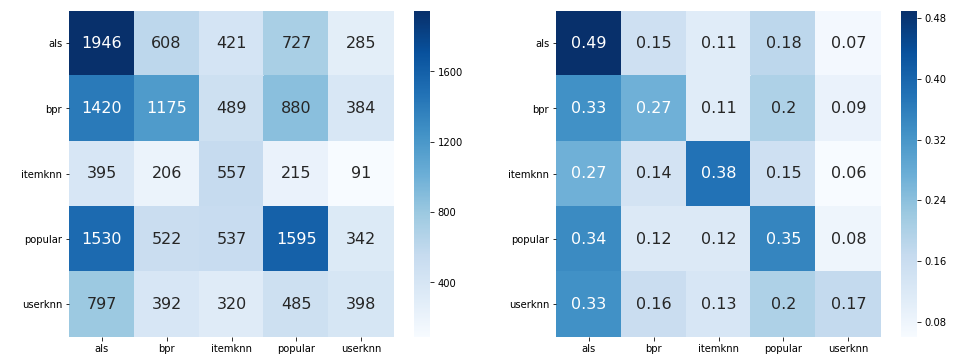

In [16]:
# whole TRAIN SET results
print_metrics(model, train[meta_features], train['class_n'], train[METRICS], mapping, train_all[METRICS])

##### 1.1.1.2 Model evaluation

accuracy:  0.28894989704873025

              precision    recall  f1-score   support

           0       0.30      0.48      0.37      1728
           1       0.36      0.23      0.28      1960
           2       0.15      0.25      0.19       653
           3       0.34      0.30      0.32      1881
           4       0.18      0.10      0.13      1063

   micro avg       0.29      0.29      0.29      7285
   macro avg       0.27      0.27      0.26      7285
weighted avg       0.30      0.29      0.28      7285

macro precision:  0.26736792614022986
micro precision:  0.28894989704873025

micro recall:  0.28894989704873025
macro recall:  0.2709541526261006

micro f1:  0.28894989704873025
macro f1:  0.2576063681071288
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.0584194862422651

Base level - best single algorithm (alg. subset):  0.03364894952474939
Base level - best single algorithm (all alg.):  0.0336489495247

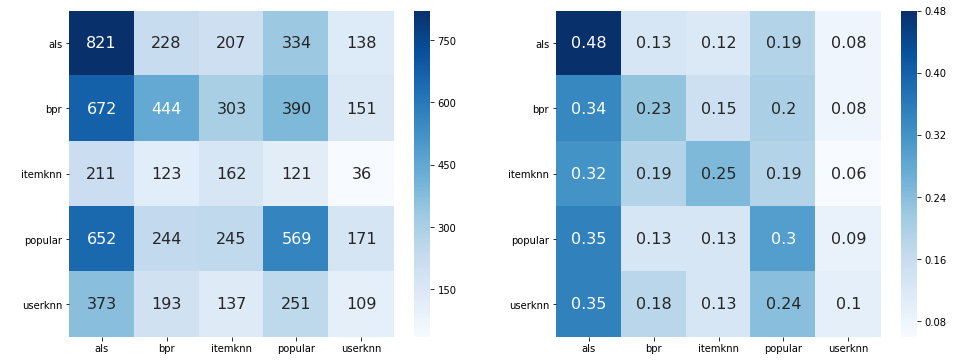

In [17]:
# TEST SET RESULTS
print_metrics(model, test[meta_features], test['class_n'], test[METRICS], mapping, test_all[METRICS])

##### 1.1.1.3 Feature importances

In [18]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(meta_features)), meta_features, model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
54,seconds_diff_min,0.050327
31,item_appearance_q1,0.050284
32,item_appearance_q2,0.041903
57,seconds_diff_q1,0.040243
58,seconds_diff_q2,0.038106
56,seconds_diff_mean,0.034698
35,item_appearance_min,0.034374
55,seconds_diff_max,0.032303
59,seconds_diff_q3,0.032018
34,item_appearance_mean,0.027966


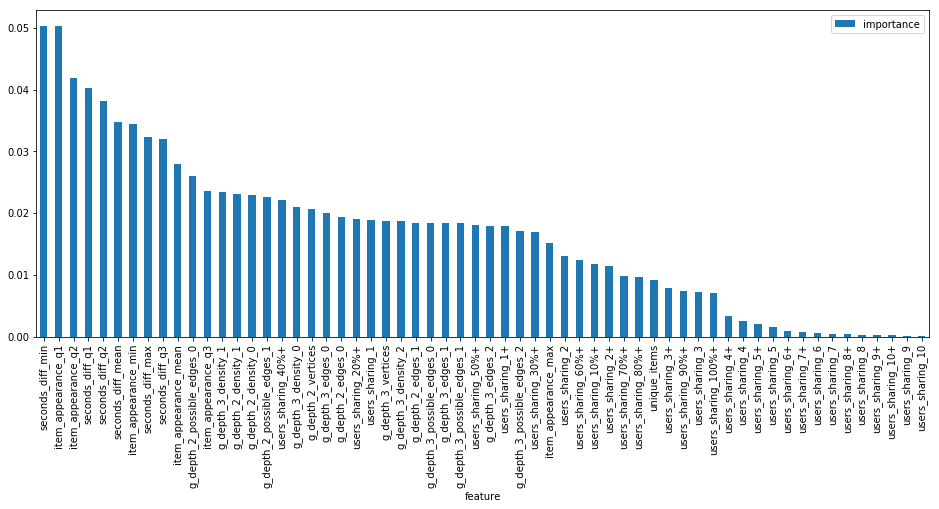

In [19]:
importances.sort_values(by='importance', ascending=False).plot(kind='bar', x='feature', y='importance')

### 1.2 Main metric to optimize: NDCG@100

In [20]:
def mean_ndcg_at_100_per_user_with_optimal_alg_in_subset(y_true, y_pred, rs_perf, mapping_dictionary):
    aux = pd.DataFrame()
    # copy performance of rs algorithms for users that are in current fold
    aux['perf'] = rs_perf.loc[y_true.index]
    aux['predicted'] = y_pred
    return aux.apply(lambda x: [p[0] for p in x.perf if mapping_dictionary.get(p[1]) == x.predicted][0], axis=1).mean()

#### 1.2.1 Complete set of base level algorithms

##### 1.2.1.1 Model training

In [21]:
%%time

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights

label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[meta_features], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 36.5 s, sys: 400 ms, total: 36.9 s
Wall time: 1min 22s


In [22]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.10067843523673801

In [23]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 600,
 'min_samples_split': 30,
 'min_samples_leaf': 15,
 'max_depth': 7,
 'criterion': 'gini'}

In [24]:
# will be used further
best_hparams = rs.best_params_
for k in best_hparams.keys():
    best_hparams[k] = [best_hparams[k]]
best_hparams

{'random_state': [1739],
 'n_estimators': [600],
 'min_samples_split': [30],
 'min_samples_leaf': [15],
 'max_depth': [7],
 'criterion': ['gini']}

accuracy:  0.33923550876353414

              precision    recall  f1-score   support

           0       0.32      0.49      0.39      3987
           1       0.40      0.27      0.32      4348
           2       0.24      0.38      0.29      1464
           3       0.41      0.35      0.38      4526
           4       0.27      0.17      0.20      2392

   micro avg       0.34      0.34      0.34     16717
   macro avg       0.33      0.33      0.32     16717
weighted avg       0.35      0.34      0.33     16717

macro precision:  0.32763399074721705
micro precision:  0.33923550876353414

micro recall:  0.33923550876353414
macro recall:  0.33151724382811965

micro f1:  0.33923550876353414
macro f1:  0.31750097623810725
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.05779478671945983

Base level - best single algorithm (alg. subset):  0.03353238027320502
Base level - best single algorithm (all alg.):  0.0335323802

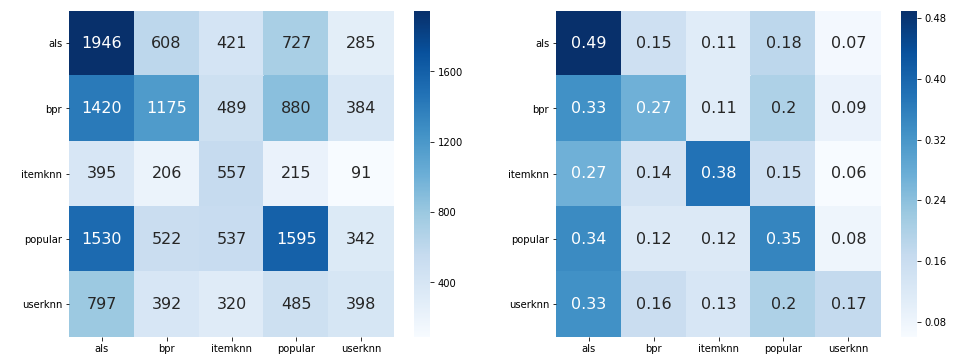

In [25]:
# whole TRAIN SET results
print_metrics(model, train[meta_features], train['class_n'], train[METRICS], mapping, train_all[METRICS])

##### 1.2.1.2 Model evaluation

accuracy:  0.28894989704873025

              precision    recall  f1-score   support

           0       0.30      0.48      0.37      1728
           1       0.36      0.23      0.28      1960
           2       0.15      0.25      0.19       653
           3       0.34      0.30      0.32      1881
           4       0.18      0.10      0.13      1063

   micro avg       0.29      0.29      0.29      7285
   macro avg       0.27      0.27      0.26      7285
weighted avg       0.30      0.29      0.28      7285

macro precision:  0.26736792614022986
micro precision:  0.28894989704873025

micro recall:  0.28894989704873025
macro recall:  0.2709541526261006

micro f1:  0.28894989704873025
macro f1:  0.2576063681071288
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.0584194862422651

Base level - best single algorithm (alg. subset):  0.03364894952474939
Base level - best single algorithm (all alg.):  0.0336489495247

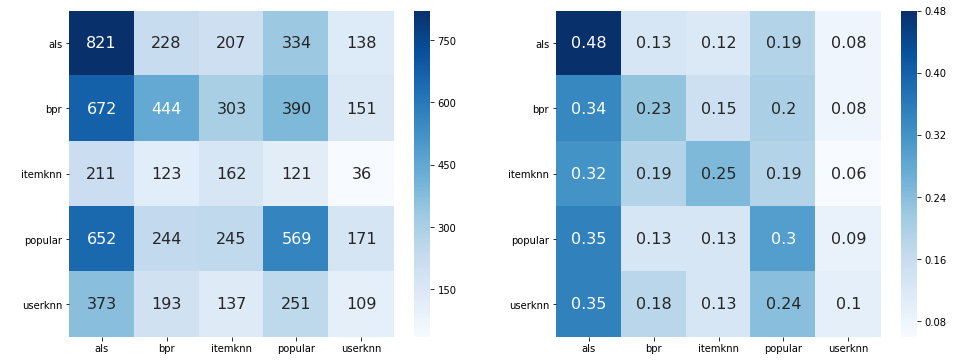

In [26]:
# TEST SET RESULTS
print_metrics(model, test[meta_features], test['class_n'], test[METRICS], mapping, test_all[METRICS])

##### 1.2.1.3 Feature importances

In [27]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(meta_features)), meta_features, model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
54,seconds_diff_min,0.050327
31,item_appearance_q1,0.050284
32,item_appearance_q2,0.041903
57,seconds_diff_q1,0.040243
58,seconds_diff_q2,0.038106
56,seconds_diff_mean,0.034698
35,item_appearance_min,0.034374
55,seconds_diff_max,0.032303
59,seconds_diff_q3,0.032018
34,item_appearance_mean,0.027966


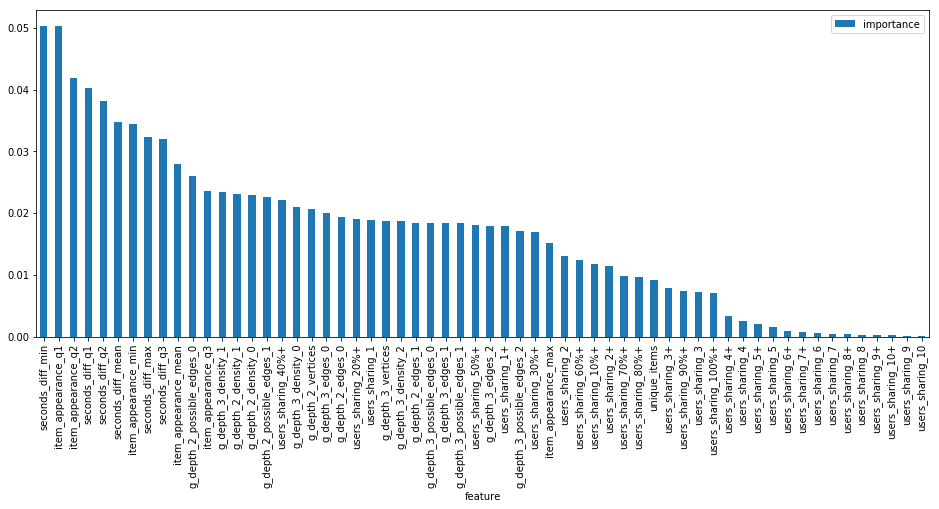

In [28]:
importances.sort_values(by='importance', ascending=False).plot(kind='bar', x='feature', y='importance')

#### 1.2.2 Searching for optimal subset of base level algorithms and features

In [31]:
def get_class_from_alg_subset(perf, subset):
    subset_perf = [x[1] for x in perf if x[1] in subset and x[0] > 0]
    if len(subset_perf) == 0:
        return None
    return subset_perf[0]

def compute_particle_performance(particle):
    alg_mask = particle[:5]
    feature_mask = particle[5:]
    
    alg_subset = np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[alg_mask == 1]
    
    # penalize if particle is using less than 2 rs algorithms
    if len(alg_subset) < 2:
        return 1
    
    # compute class per user based on alg_mask
    train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, alg_subset))
    train = train_all.dropna(axis=0)
    
    # mapping of class labels
    train['class_n'] = train['class'].astype('category').cat.codes
    mapping = train.groupby('class')['class_n'].max().to_dict()
    
    # needs to be updated for each subset of rs algorithms
    ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                              rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

    # use 5-fold cross validation and balance label weights
    label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
    cv = RandomizedSearchCV(RandomForestClassifier(), best_hparams, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS,
                            n_iter=1, random_state=RAND_STATE, error_score=0)
    cv.fit(train[np.array(meta_features)[feature_mask == 1]], train['class_n'], sample_weight=label_weights)
    
    # score calculation is based on all users in train set
    #
    # cv.best_score_ is mean score per user in validation sets
    #
    # multiplying by number of users in all validation sets (=train users with existing optimal rs algorithm) 
    # and dividing by all users in train set (also those with not existing optimal algorithm) gives estimation
    # of mean ndcg per user
    particles_performance['mask'].append(particle)
    particles_performance['performance'].append(cv.best_score_ * len(train) / len(train_all))
    return 1 - (cv.best_score_ * len(train) / len(train_all))

def compute_particles_performance(particles):
    return np.array([compute_particle_performance(p) for p in particles])

In [32]:
%%time
# TODO update
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': 10, 'p':2}
mask_length = 5 + len(meta_features)
optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=mask_length, options=options)
particles_performance = {'mask': [], 'performance': []}
cost, pos = optimizer.optimize(compute_particles_performance, iters=20)

2020-04-30 19:12:47,595 - pyswarms.discrete.binary - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 2, 'p': 2}

pyswarms.discrete.binary:   0%|          |0/2

using subset: ['bpr' 'userknn']
NDCG@100: 0.02957173803574597
using subset: ['als' 'bpr']



pyswarms.discrete.binary:   0%|          |0/2, best_cost=0.966
pyswarms.discrete.binary:  50%|█████     |1/2, best_cost=0.966

NDCG@100: 0.033828051816065026
using subset: ['bpr' 'itemknn' 'userknn' 'popular']
NDCG@100: 0.025356289275093105
using subset: ['bpr' 'itemknn' 'userknn' 'popular']



pyswarms.discrete.binary:  50%|█████     |1/2, best_cost=0.966
pyswarms.discrete.binary: 100%|██████████|2/2, best_cost=0.966
2020-04-30 19:16:42,001 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9661719481839349, best pos: [1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1
 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0]


NDCG@100: 0.02524447991796657
CPU times: user 1min 53s, sys: 1.21 s, total: 1min 54s
Wall time: 3min 54s


In [33]:
particles_performance = pd.DataFrame(particles_performance)

In [34]:
particles_performance['algorithms'] = particles_performance['mask'].apply(lambda x: 
                                         np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[x[:5] == 1])
particles_performance['features_included'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 1])
particles_performance['features_excluded'] = particles_performance['mask'].apply(lambda x: np.array(meta_features)[x[5:] == 0])

particles_performance['n_algorithms'] = particles_performance['algorithms'].apply(lambda x: len(x))
particles_performance['n_features_included'] = particles_performance['features_included'].apply(lambda x: len(x))
particles_performance['n_features_excluded'] = particles_performance['features_excluded'].apply(lambda x: len(x))

In [35]:
particles_performance.sort_values(by='performance', ascending=False).head()

,mask,performance,algorithms,features_included,features_excluded,n_algorithms,n_features_included,n_features_excluded
1,"[1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, ...",0.033828,"[als, bpr]","[users_sharing_1, users_sharing_10%+, users_sh...","[unique_items, users_sharing_1+, users_sharing...",2,28,32
0,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, ...",0.029572,"[bpr, userknn]","[unique_items, users_sharing_1+, users_sharing...","[users_sharing_1, users_sharing_10%+, users_sh...",2,28,32
2,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, ...",0.025356,"[bpr, itemknn, userknn, popular]","[users_sharing_1, users_sharing_2+, users_shar...","[unique_items, users_sharing_1+, users_sharing...",4,34,26
3,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, ...",0.025244,"[bpr, itemknn, userknn, popular]","[users_sharing_1, users_sharing_2+, users_shar...","[unique_items, users_sharing_1+, users_sharing...",4,32,28


In [36]:
# TODO update
particles_performance.to_csv(DATA_PATH+'meta/bpso/rf_independent.csv', index=False)

In [37]:
print('Best model NDCG:', 1-cost)
print('Algorithms subset:', np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1])
print('Features used:', list(pos[5:]).count(1))
print('Features excluded:', list(pos[5:]).count(0))

Best model NDCG: 0.033828051816065074
Algorithms subset: ['als' 'bpr']
Features used: 28
Features excluded: 32


In [38]:
# used meta features
np.array(meta_features)[pos[5:] == 1]

array(['users_sharing_1', 'users_sharing_10%+', 'users_sharing_20%+',
       'users_sharing_3', 'users_sharing_30%+', 'users_sharing_40%+',
       'users_sharing_5+', 'users_sharing_60%+', 'users_sharing_70%+',
       'users_sharing_8', 'users_sharing_8+', 'users_sharing_80%+',
       'users_sharing_9+', 'users_sharing_90%+', 'users_sharing_100%+',
       'item_appearance_q1', 'item_appearance_mean', 'g_depth_2_vertices',
       'g_depth_2_possible_edges_0', 'g_depth_2_density_0',
       'g_depth_2_density_1', 'g_depth_3_vertices', 'g_depth_3_edges_0',
       'g_depth_3_edges_1', 'g_depth_3_density_2', 'seconds_diff_min',
       'seconds_diff_max', 'seconds_diff_q1'], dtype='<U26')

In [39]:
# excluded meta features
np.array(meta_features)[pos[5:] == 0]

array(['unique_items', 'users_sharing_1+', 'users_sharing_2',
       'users_sharing_2+', 'users_sharing_3+', 'users_sharing_4',
       'users_sharing_4+', 'users_sharing_5', 'users_sharing_50%+',
       'users_sharing_6', 'users_sharing_6+', 'users_sharing_7',
       'users_sharing_7+', 'users_sharing_9', 'users_sharing_10',
       'users_sharing_10+', 'item_appearance_q2', 'item_appearance_q3',
       'item_appearance_min', 'item_appearance_max', 'g_depth_2_edges_1',
       'g_depth_3_edges_2', 'g_depth_2_edges_0',
       'g_depth_2_possible_edges_1', 'g_depth_3_possible_edges_0',
       'g_depth_3_density_0', 'g_depth_3_possible_edges_1',
       'g_depth_3_density_1', 'g_depth_3_possible_edges_2',
       'seconds_diff_mean', 'seconds_diff_q2', 'seconds_diff_q3'],
      dtype='<U26')

#### 1.2.3 Tuning model using algorithm and feature subsets

In [40]:
%%time

# compute class per user based on alg_mask
train_all['class'] = train_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
train = train_all.dropna(axis=0)
test_all['class'] = test_all[METRICS[0]].apply(lambda x: get_class_from_alg_subset(x, np.array(['als', 'bpr', 'itemknn', 'userknn', 'popular'])[pos[:5] == 1]))
test = test_all.dropna(axis=0)

# mapping of class labels
train['class_n'] = train['class'].astype('category').cat.codes
mapping = train.groupby('class')['class_n'].max().to_dict()
test['class_n'] = test['class'].apply(lambda x: mapping[x])

# needs to be updated for each subset of rs algorithms
ndcg_scorer = make_scorer(mean_ndcg_at_100_per_user_with_optimal_alg_in_subset, greater_is_better=True,
                          rs_perf=train[METRICS[0]], mapping_dictionary=mapping)

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 27.9 s, sys: 188 ms, total: 28.1 s
Wall time: 55.1 s


In [41]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.17760769991714534

In [42]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 600,
 'min_samples_split': 30,
 'min_samples_leaf': 15,
 'max_depth': 7,
 'criterion': 'gini'}

accuracy:  0.6304386119429276

              precision    recall  f1-score   support

           0       0.58      0.65      0.61      5084
           1       0.68      0.62      0.65      6270

   micro avg       0.63      0.63      0.63     11354
   macro avg       0.63      0.63      0.63     11354
weighted avg       0.64      0.63      0.63     11354

macro precision:  0.6307845667106051
micro precision:  0.6304386119429276

micro recall:  0.6304386119429276
macro recall:  0.6322217056481415

micro f1:  0.6304386119429276
macro f1:  0.6295502681172571
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.04228412611368871

Base level - best single algorithm (alg. subset):  0.03353238027320503
Base level - best single algorithm (all alg.):  0.03353238027320502

Possible absolute improvement (alg. subset):  0.008751745840483681
Possible absolute improvement (all alg.):  0.008751745840483688

Possible relative improvemen

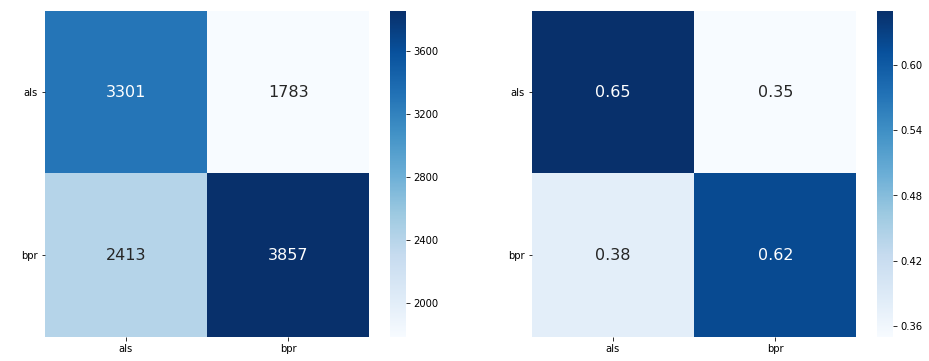

In [43]:
# whole TRAIN SET results
print_metrics(model, train[np.array(meta_features)[pos[5:] == 1]], train['class_n'], train[METRICS], mapping, train_all[METRICS])

##### 1.2.3.1 Model evaluation

accuracy:  0.5777643989564519

              precision    recall  f1-score   support

           0       0.51      0.59      0.55      2172
           1       0.64      0.56      0.60      2811

   micro avg       0.58      0.58      0.58      4983
   macro avg       0.58      0.58      0.58      4983
weighted avg       0.59      0.58      0.58      4983

macro precision:  0.5784024803076282
micro precision:  0.5777643989564519

micro recall:  0.5777643989564519
macro recall:  0.5797056158619158

micro f1:  0.5777643989564519
macro f1:  0.5762793461687188
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.042479231379205395

Base level - best single algorithm (alg. subset):  0.03364894952474939
Base level - best single algorithm (all alg.):  0.03364894952474939

Possible absolute improvement (alg. subset):  0.008830281854456008
Possible absolute improvement (all alg.):  0.008830281854456008

Possible relative improveme

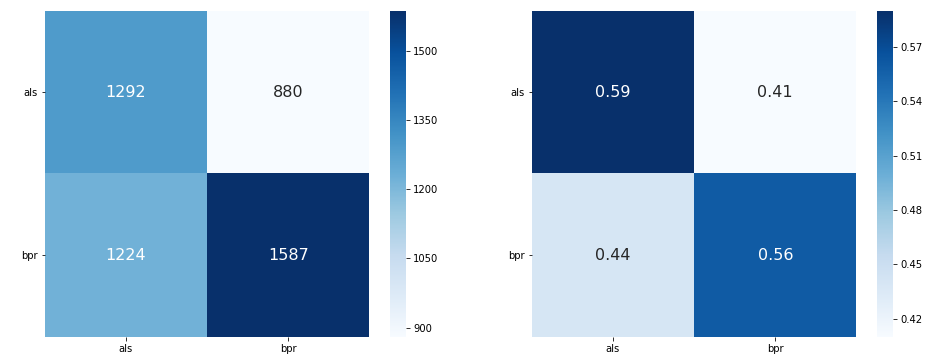

In [44]:
# TEST SET RESULTS
print_metrics(model, test[np.array(meta_features)[pos[5:] == 1]], test['class_n'], test[METRICS], mapping, test_all[METRICS])

##### 1.2.3.2 Feature importances

In [45]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(meta_features)), meta_features, model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
24,users_sharing_80%+,0.092063
18,users_sharing_60%+,0.075654
0,unique_items,0.073423
17,users_sharing_6+,0.064695
21,users_sharing_70%+,0.062826
23,users_sharing_8+,0.060196
22,users_sharing_8,0.058048
25,users_sharing_9,0.056236
26,users_sharing_9+,0.053416
16,users_sharing_6,0.052979


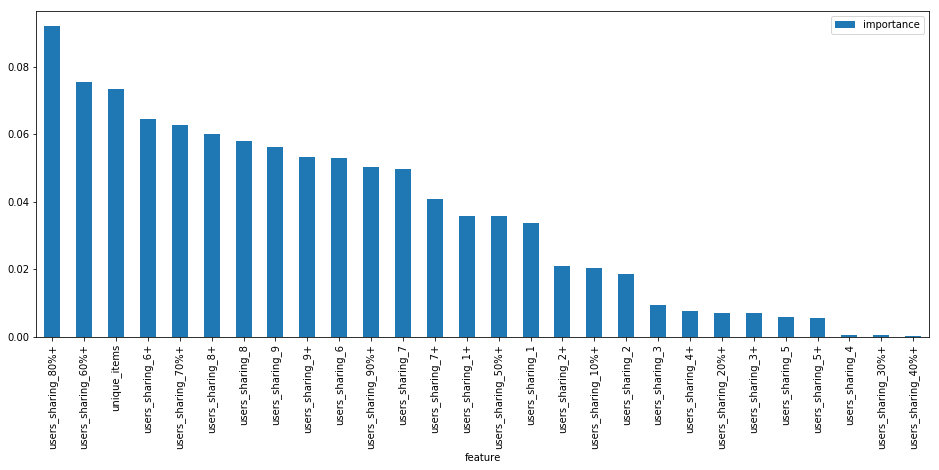

In [46]:
importances.sort_values(by='importance', ascending=False).plot(kind='bar', x='feature', y='importance')

#### 1.2.4 Tuning model using algorithm subset only

In [47]:
%%time

# use random search with 5-fold cross validation and balance label weights
label_weights = class_weight.compute_sample_weight('balanced', train['class_n'])
params = {
    'n_estimators': list(range(50, 1050, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 26)) + [None],
    'min_samples_split': list(range(5, 55, 5)),
    'min_samples_leaf': list(range(5, 35, 5)),
    'random_state': [RAND_STATE]
}
rs = RandomizedSearchCV(RandomForestClassifier(), params, scoring=ndcg_scorer, cv=CV_FOLDS, n_jobs=NUM_THREADS, n_iter=RS_ITERATIONS, random_state=RAND_STATE, error_score=0)
rs.fit(train[meta_features], train['class_n'], sample_weight=label_weights)
model = rs.best_estimator_

CPU times: user 19.6 s, sys: 32 ms, total: 19.7 s
Wall time: 50.3 s


In [48]:
# best model's mean ndcg@100 on validation sets of users with existing optimal rs algorithm
rs.best_score_

0.1778202047948232

In [49]:
rs.best_params_

{'random_state': 1739,
 'n_estimators': 600,
 'min_samples_split': 30,
 'min_samples_leaf': 15,
 'max_depth': 7,
 'criterion': 'gini'}

accuracy:  0.6322881803769597

              precision    recall  f1-score   support

           0       0.58      0.65      0.61      5084
           1       0.69      0.62      0.65      6270

   micro avg       0.63      0.63      0.63     11354
   macro avg       0.63      0.63      0.63     11354
weighted avg       0.64      0.63      0.63     11354

macro precision:  0.632530159735802
micro precision:  0.6322881803769597

micro recall:  0.6322881803769597
macro recall:  0.6339893615018879

micro f1:  0.6322881803769597
macro f1:  0.6313688738554122
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.04228412611368871

Base level - best single algorithm (alg. subset):  0.03353238027320503
Base level - best single algorithm (all alg.):  0.03353238027320502

Possible absolute improvement (alg. subset):  0.008751745840483681
Possible absolute improvement (all alg.):  0.008751745840483688

Possible relative improvement

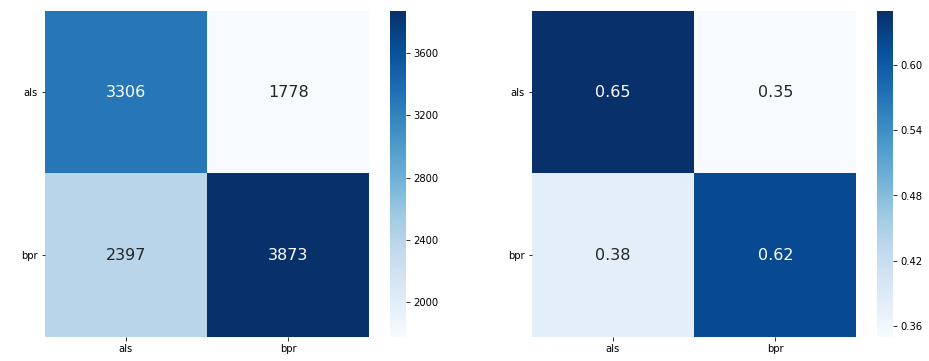

In [50]:
# whole TRAIN SET results
print_metrics(model, train[meta_features], train['class_n'], train[METRICS], mapping, train_all[METRICS])

##### 1.2.4.1 Model evaluation

accuracy:  0.58298213927353

              precision    recall  f1-score   support

           0       0.52      0.60      0.56      2172
           1       0.65      0.57      0.61      2811

   micro avg       0.58      0.58      0.58      4983
   macro avg       0.58      0.58      0.58      4983
weighted avg       0.59      0.58      0.58      4983

macro precision:  0.5834104199893673
micro precision:  0.58298213927353

micro recall:  0.58298213927353
macro recall:  0.5848012740005228

micro f1:  0.58298213927353
macro f1:  0.5814345101234999
Impact on recommendation - NDCG@100 :
Teoretical maximum that can be achieved with perfect classifier (alg. subset): 0.042479231379205395

Base level - best single algorithm (alg. subset):  0.03364894952474939
Base level - best single algorithm (all alg.):  0.03364894952474939

Possible absolute improvement (alg. subset):  0.008830281854456008
Possible absolute improvement (all alg.):  0.008830281854456008

Possible relative improvement (alg.

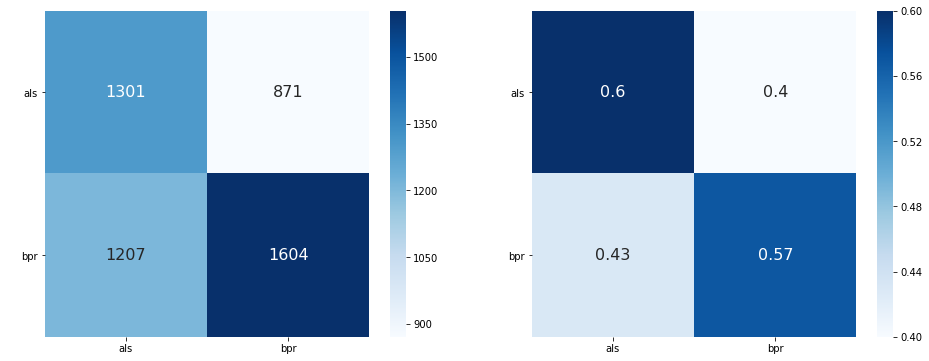

In [51]:
# TEST SET RESULTS
print_metrics(model, test[meta_features], test['class_n'], test[METRICS], mapping, test_all[METRICS])

##### 1.2.4.2 Feature importances

In [52]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(meta_features)), meta_features, model.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
53,g_depth_3_density_2,0.052970
41,g_depth_2_possible_edges_0,0.038420
48,g_depth_3_possible_edges_0,0.035139
52,g_depth_3_possible_edges_2,0.034457
1,users_sharing_1,0.034198
50,g_depth_3_possible_edges_1,0.029974
51,g_depth_3_density_1,0.029351
54,seconds_diff_min,0.028897
33,item_appearance_q3,0.028708
38,g_depth_3_edges_2,0.028591


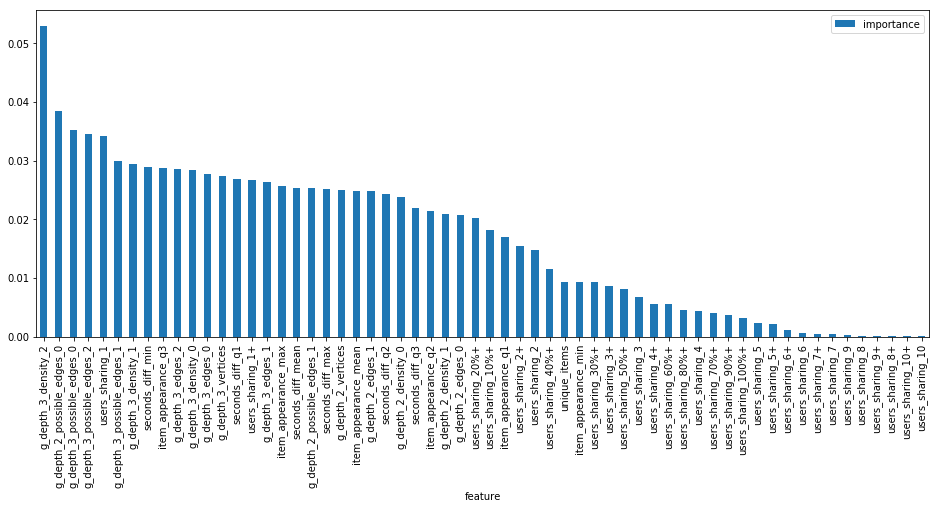

In [53]:
importances.sort_values(by='importance', ascending=False).plot(kind='bar', x='feature', y='importance')

## 2 Domain Independent + Domain Specific Meta Features